# **Shakespeare-Style Text Generation with LSTM Networks**

This notebook demonstrates the implementation of a Causal Language Model for text generation in the style of Shakespeare, using an [LSTM network](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and a [dataset containing Shakespeare's writings](https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt).

For a more robust implementation, please visit my following [notebook](https://github.com/JersonGB22/CausalLanguageModeling-TensorFlow/blob/main/models_transformers/CausalLM_DistilGPT2_Shakespeare.ipynb), where a Transformer model is implemented for text generation, achieving better results.

## **Imports**

In [1]:
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
from tqdm.auto import tqdm

## **Parameters**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
seq_length = 128
batch_size = 64
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
embedding_dim = 256
epochs = 50

## **Load and Preprocess the Dataset**

In [3]:
# Download the dataset
dataset_path = tf.keras.utils.get_file(
    fname="shakespeare.txt",
    origin="https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt"
)

# Read the dataset
with open(dataset_path, "r") as file:
  text = file.read()

# View an excerpt of Shakespeare's text
print(f"Length of text: {len(text)} characters", "\n")
print(f"Text Extract:\n\n{text[:1000]}")

Length of text: 1115394 characters 

Text Extract:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak th

### **Text Tokenization**

For tokenization, the [``tf.keras.layers.StringLookup``](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) layer is used to convert each character into a numeric identifier. To perform the reverse process of converting ids back to strings, the same layer is utilized with the parameter ``invert=True``.

In [4]:
# Custom class to tokenize characters from the dataset
class Tokenizer():
  def __init__(self, text):
    initial_vocab = sorted(set(text))
    self.chars_to_ids = tf.keras.layers.StringLookup(vocabulary=initial_vocab)
    self.vocab = self.chars_to_ids.get_vocabulary()
    self.ids_to_chars = tf.keras.layers.StringLookup(vocabulary=self.vocab, invert=True)
    self.vocab_size = self.chars_to_ids.vocabulary_size()

  def text_to_ids(self, text):
    text = tf.strings.unicode_split(text, input_encoding="UTF-8")
    ids = self.chars_to_ids(text)
    return ids

  def ids_to_text(self, ids):
    chars = self.ids_to_chars(ids)
    chars = tf.strings.reduce_join(chars, axis=-1).numpy().decode("utf-8")
    return chars

In [5]:
tokenizer = Tokenizer(text)
dataset = tokenizer.text_to_ids(text)
vocab = tokenizer.vocab
vocab_size = tokenizer.vocab_size

print(vocab_size)
print(vocab)

66
['[UNK]', '\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# Observe the results of tokenization
print(dataset[:100].numpy(), "\n")
tokenizer.ids_to_text(dataset[:100])

[19 48 57 58 59  2 16 48 59 48 65 44 53 11  1 15 44 45 54 57 44  2 62 44
  2 55 57 54 42 44 44 43  2 40 53 64  2 45 60 57 59 47 44 57  7  2 47 44
 40 57  2 52 44  2 58 55 44 40 50  9  1  1 14 51 51 11  1 32 55 44 40 50
  7  2 58 55 44 40 50  9  1  1 19 48 57 58 59  2 16 48 59 48 65 44 53 11
  1 38 54 60] 



'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

### **Create the Training and Evaluation Datasets**

In [7]:
def create_datasets(dataset, val_size=0.15):
  def split_input_label(sequence):
    inputs = sequence[:-1]
    labels = sequence[1:] #The 'labels' are simply the 'ids' shifted one position to the right
    return inputs, labels

  N = int(len(dataset) * val_size)
  train_dataset = dataset[:-N]
  val_dataset = dataset[-N:]

  train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
  val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
  train_dataset = train_dataset.batch(seq_length + 1, drop_remainder=True)
  val_dataset = val_dataset.batch(seq_length + 1, drop_remainder=True)

  train_dataset = (
      train_dataset.
      map(split_input_label).
      shuffle(buffer_size, seed=SEED).
      batch(batch_size).
      prefetch(AUTOTUNE)
  )

  val_dataset = (
      val_dataset.
      map(split_input_label).
      batch(batch_size).
      prefetch(AUTOTUNE)
  )

  return train_dataset, val_dataset

In [8]:
train_dataset, val_dataset = create_datasets(dataset)

In [9]:
# Viewing a training batch
for inputs, labels in train_dataset.take(1):
  print(inputs, "\n")
  print(labels)

tf.Tensor(
[[ 2 47 44 ... 44 58 54]
 [47 44 40 ... 45  2 40]
 [62 44  2 ... 54 42 44]
 ...
 [53 59 11 ...  2 59 47]
 [ 6  3  2 ... 59  2 47]
 [47 48 52 ...  2 59 47]], shape=(64, 128), dtype=int64) 

tf.Tensor(
[[47 44 51 ... 58 54 51]
 [44 40 57 ...  2 40 60]
 [44  2 41 ... 42 44 44]
 ...
 [59 11  1 ... 59 47 40]
 [ 3  2  6 ...  2 47 40]
 [48 52  2 ... 59 47 44]], shape=(64, 128), dtype=int64)


## **Creation and Training of the Model**

The model can be created using TensorFlow's sequential or functional API directly. However, to significantly speed up text generation, it's essential to implement a custom model that returns the internal state of the LSTM to be passed to the next step when generating each character. This approach is preferred over predicting complete sequences at each prediction step.

In [9]:
@tf.keras.saving.register_keras_serializable()
class Model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.lstm = tf.keras.layers.LSTM(embedding_dim, return_sequences=True, return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False):
    x = self.embedding(inputs)
    if states is None:
      states = self.lstm.get_initial_state(x)
    x, last_hs, last_cs = self.lstm(x, initial_state=states) #(All sequence hidden states, last hidden state, last cell state)
    x = self.dense(x)

    if return_state:
      return x, [last_hs, last_cs]
    else:
      return x

In [11]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = Model()
model.build(input_shape=(None, None)) #None: variable sequences
model.call(tf.keras.Input(shape=(None,)))

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         16896     
                                                                 
 lstm (LSTM)                 [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 dense (Dense)               (None, None, 66)          16962     
                                                                 
Total params: 559170 (2.13 MB)
Trainable params: 559170 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Example of prediction before training the model

example = inputs[0]
pred_example = model.predict(example[None, :], verbose=0)[0]
pred_example = np.argmax(pred_example, axis=-1)
tokenizer.ids_to_text(pred_example)

'F$R;;FFFFFRRFFRRRuVVVVVVuuuxxxOORRRFFFFRFjuuRRRV;;;Fuuu;u;VFRRRRFRRR;;F;Fg\nOKFVRRFKVV?FVR;;KVpuuubbKnxFFFFFFRFjuKnnxuRR;;;;F;;aR'

It can be observed that before training the model, it generates completely random text.

In [13]:
# Callback to stop training early if validation loss does not decrease for 2 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    mode="min",
    restore_best_weights=True
)

In [14]:
# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

In [15]:
# Train the model

tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/50
115/115 [==============================] - 7s 31ms/step - loss: 3.0322 - val_loss: 2.4649
Epoch 2/50
115/115 [==============================] - 3s 21ms/step - loss: 2.3173 - val_loss: 2.2202
Epoch 3/50
115/115 [==============================] - 3s 21ms/step - loss: 2.1226 - val_loss: 2.0814
Epoch 4/50
115/115 [==============================] - 5s 38ms/step - loss: 1.9924 - val_loss: 1.9954
Epoch 5/50
115/115 [==============================] - 4s 29ms/step - loss: 1.8957 - val_loss: 1.9344
Epoch 6/50
115/115 [==============================] - 5s 36ms/step - loss: 1.8195 - val_loss: 1.8933
Epoch 7/50
115/115 [==============================] - 7s 55ms/step - loss: 1.7582 - val_loss: 1.8605
Epoch 8/50
115/115 [==============================] - 3s 25ms/step - loss: 1.7071 - val_loss: 1.8352
Epoch 9/50
115/115 [==============================] - 3s 26ms/step - loss: 1.6650 - val_loss: 1.8147
Epoch 10/50
115/115 [==============================] - 4s 31ms/step - loss: 1.6300 - val_lo

**Save model**

In [7]:
trained_model_path = "/content/drive/MyDrive/models/CausalLM_LSTM_Shakespeare.keras"

In [17]:
model.save(trained_model_path)

## **Model Evaluation**

In [19]:
loss_train = model.evaluate(train_dataset, verbose=0)
loss_val = model.evaluate(val_dataset, verbose=0)
print(f"Training Dataset:\nLoss: {loss_train}\tPerplexity: {np.exp(loss_train)}\n")
print(f"Validation Dataset:\nLoss: {loss_val}\tPerplexity: {np.exp(loss_val)}")

Training Dataset:
Loss: 1.345813512802124	Perplexity: 3.8413102248939723

Validation Dataset:
Loss: 1.6662834882736206	Perplexity: 5.292461704914405


In [20]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [21]:
plot_metrics()

**Images for GitHub**

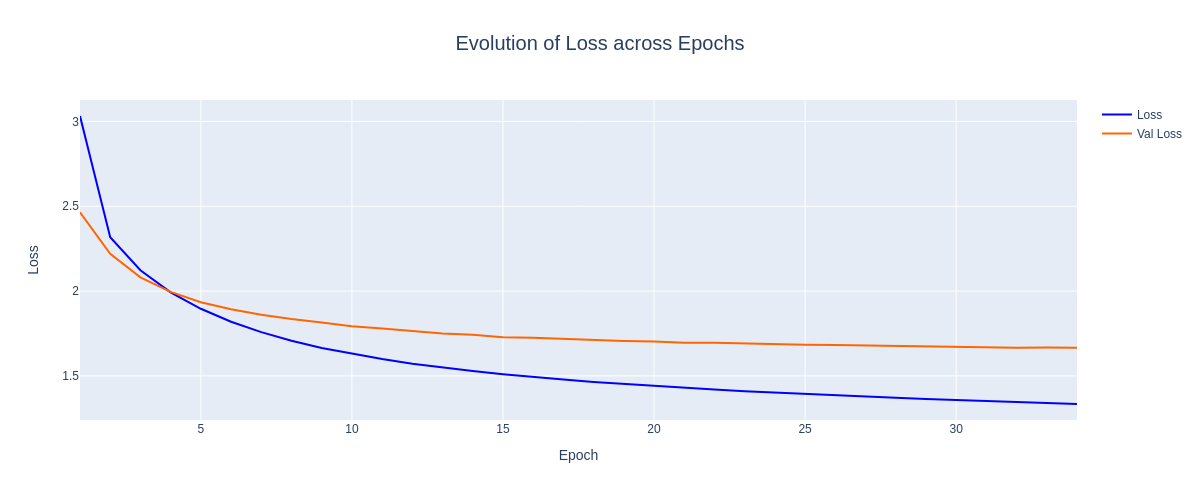

In [22]:
plot_metrics(renderer="png")

## **Text Generation with the Trained Model**

In [10]:
# Load the trained model
tf.keras.backend.clear_session()

model = tf.keras.models.load_model(trained_model_path)
model.call(tf.keras.Input(shape=(None,)))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         16896     
                                                                 
 lstm (LSTM)                 [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 dense (Dense)               (None, None, 66)          16962     
                                                                 
Total params: 559170 (2.13 MB)
Trainable params: 559170 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The custom class for text generation selects characters by sampling from the output distribution using `tf.random.categorical`. This distribution is based on the logits over the character vocabulary. Using `argmax` instead of this technique could cause the model to get stuck in a loop, continuously repeating the same characters.

Temperature is also considered for predictions. A value of 1.0 does not affect the predictions; a value less than 1.0 makes them more deterministic and precise, although a value very close to 0 can cause the model to get stuck in a loop generating the same characters. A value greater than 1.0 produces more creative and less precise, more random predictions. In this case, a value of 0.75 is used to achieve a good balance between coherence and creativity, which is useful for generating interesting and varied text without losing too much structure.

In [69]:
class GenerateText(Tokenizer):
  def __init__(self, temperature=1.0):
    super().__init__(text)
    self.temperature = temperature
    # Mask to discard the ID 0 ([UNK])
    self.mask = tf.scatter_nd([[0]], [-float("inf")], [self.vocab_size])

  @tf.function
  def generate_one_step(self, inputs, states):
    input_ids = self.text_to_ids(inputs)
    logits, states = model(input_ids, states=states, return_state=True)
    logits = logits.to_tensor()[:, -1, :]
    logits /= self.temperature
    logits += self.mask

    predicted_ids = tf.random.categorical(logits, num_samples=1)[0]
    predicted_char = self.ids_to_chars(predicted_ids)

    return predicted_char, states

  def generate_chars(self, num_chars=100, prefix=" "):
    next_char = tf.constant([prefix])
    # Shade the prefix in yellow
    prefix = f"<span style='background-color: yellow;'>{prefix}</span>"
    states = None

    for _ in tqdm(range(num_chars)):
      next_char, states = self.generate_one_step(next_char, states)
      prefix += next_char.numpy()[0].decode("utf-8")
    
    # Replace '\n' with '<br>' to make the line break visible in HTML format
    prefix = prefix.replace("\n", "<br>")
    
    display(HTML(f"<b>GENERATED TEXT:</b><br><br>"))
    display(HTML(prefix))

In [75]:
text_generator = GenerateText(temperature=0.75)

In [148]:
text_generator.generate_chars(num_chars=1000, prefix="K")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [92]:
text_generator.generate_chars(num_chars=500, prefix="QUEEN")

  0%|          | 0/500 [00:00<?, ?it/s]

In [97]:
text_generator.generate_chars(num_chars=2000, prefix="Dear")

  0%|          | 0/2000 [00:00<?, ?it/s]

In [103]:
text_generator.generate_chars(
    num_chars=1000,
    prefix="O fair and noble maiden,"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

**Conclusion:** The text generation model has successfully captured the structure of a theatrical work, beginning text blocks with speakers' names in uppercase. However, coherence is partial; while some phrases are grammatically correct, most lack complete meaning. In terms of style, the model has partly adopted Shakespeare's style, using language and sentence structures reminiscent of his works, though overall coherence remains a challenge. To achieve better results, expanding the dataset and/or employing more advanced models like Transformers, such as GPT-2, is necessary.